In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((475, 12, 1), (475,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 17s 232ms/step - loss: 0.1613 - root_mean_squared_error: 0.4016 - val_loss: 0.0449 - val_root_mean_squared_error: 0.2120
Epoch 2/50
48/48 [==============================] - 8s 159ms/step - loss: 0.1139 - root_mean_squared_error: 0.3375 - val_loss: 0.0439 - val_root_mean_squared_error: 0.2094
Epoch 3/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0909 - root_mean_squared_error: 0.3015 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2127
Epoch 4/50
48/48 [==============================] - 7s 148ms/step - loss: 0.0819 - root_mean_squared_error: 0.2862 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2062
Epoch 5/50
48/48 [==============================] - 8s 160ms/step - loss: 0.0689 - root_mean_squared_error: 0.2624 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2057
Epoch 6/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0412 - root_mean_squared_error: 0.2030 - val_loss: 0.0673 - val_r

48/48 [==============================] - 1s 17ms/step - loss: 0.0112 - root_mean_squared_error: 0.1056 - val_loss: 0.0490 - val_root_mean_squared_error: 0.2213
Epoch 46/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2738
Epoch 47/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2342
Epoch 48/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0554 - val_root_mean_squared_error: 0.2353
Epoch 49/50
48/48 [==============================] - 1s 19ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2533
Epoch 50/50
48/48 [==============================] - 1s 20ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0710 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

1.3262967348098755 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

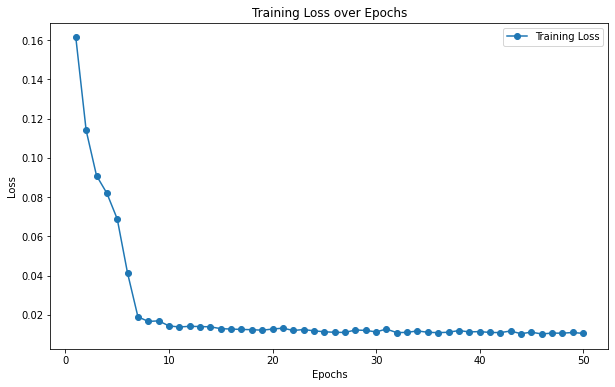

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

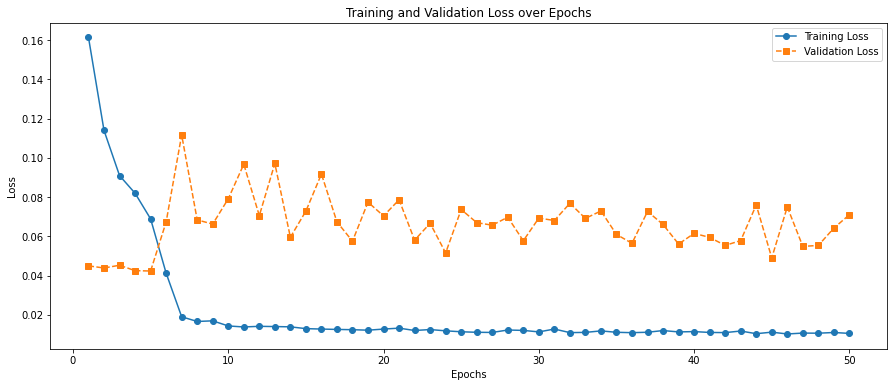

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 9ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.20861361853703606
MAE : 0.19336031936576323


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,365533.562500,151973.751
1,378283.125000,466524.938
2,374660.062500,708542.184
3,362386.500000,652598.000
4,341087.625000,414216.785
5,314520.093750,236263.303
6,286944.468750,43422.368
7,262126.562500,2161.744
8,262392.250000,944.181
9,297609.562500,13977.643


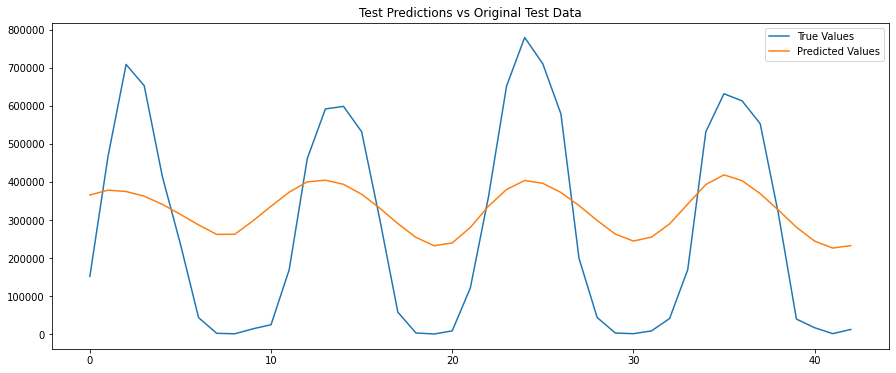

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

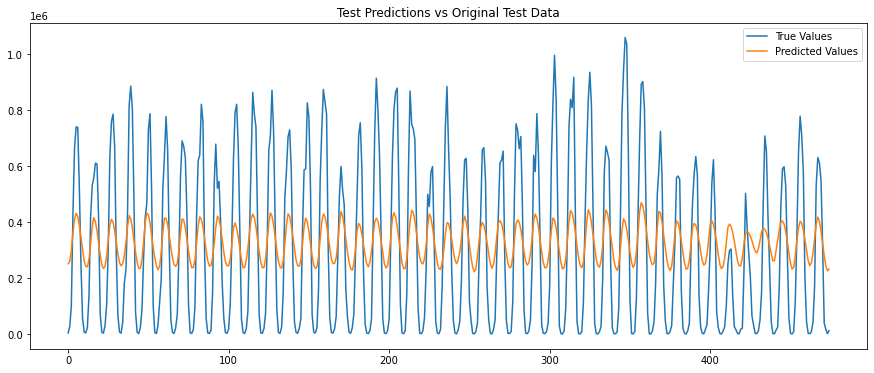

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()